In [21]:
# Predictive Sales Forecasting

# Detailed end-to-end notebook for EDA, feature engineering, modeling, evaluation, and export
# Goal: Analyze retail store data to uncover sales trends, optimize inventory, and prepare data for predictive modeling.

# Install required packages (uncomment if needed)
# !pip install pandas numpy matplotlib seaborn scikit-learn xgboost prophet shap kagglehib joblib openpyxl lightbm

In [24]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_column', None)
sns.set_style('whitegrid')

# Set workiing directory to project root
# os.chdir(r"<projet_root>")
# print("Current Directory:", os.getcwd())

In [19]:
# Load dataset
import pandas as pd
df = pd.read_csv("data/raw/retail_store_inventory.csv")
df.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


In [25]:
# Data inspection
print("Shape:", df.shape)
df.info()
df.describe(include='all').T

Shape: (73100, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Demand Forecast     73100 non-null  float64
 9   Price               73100 non-null  float64
 10  Discount            73100 non-null  int64  
 11  Weather Condition   73100 non-null  object 
 12  Holiday/Promotion   73100 non-null  int64  
 13  Competitor Pricing  73100 non-null  float64
 14  Seasonality         73100 non-null  object 
dtypes: float64(3), int64(5), object(7)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Date,73100,731,2024-01-01,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Store ID,73100,5,S001,14620,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Product ID,73100,20,P0001,3655,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Category,73100,5,Furniture,14699,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Region,73100,4,East,18349,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Inventory Level,73100.0,NaN,NaN,NaN,274.469877,129.949514,50.0,162.0,273.0,387.0,500.0
Units Sold,73100.0,NaN,NaN,NaN,136.46487,108.919406,0.0,49.0,107.0,203.0,499.0
Units Ordered,73100.0,NaN,NaN,NaN,110.004473,52.277448,20.0,65.0,110.0,155.0,200.0
Demand Forecast,73100.0,NaN,NaN,NaN,141.49472,109.254076,-9.99,53.67,113.015,208.0525,518.55
Price,73100.0,NaN,NaN,NaN,55.135108,26.021945,10.0,32.65,55.05,77.86,100.0


# Observations

- 73,100 rows - indicates daily-level data for multiple stores and products.
- Columns like `Inventory Level`, `Units Sold`, and `Demand Forecast` are continueous numeric values.
- Date, Store ID, and Product ID define granularity.

In [29]:
# Handle missing values
missing = df.isnull().sum()
print("Missing values per column:\n", missing[missing > 0])

# Drop rows with NaN in critical numeric columns
df.dropna(subset=['Inventory Level', 'Units Sold', 'Units Ordered', 'Demand Forecast'], inplace=True)
df.reset_index(drop=True, inplace=True)

print("After cleaning:", df.shape)

Missing values per column:
 Series([], dtype: int64)
After cleaning: (73100, 15)


## Note:
The NaN values seen in `df.describe()` are from categorical columns (text data), not actual missing numeric values.  
Using `df.isna().sum()` confirms that numeric fields are complete.  
No rows were dropped during cleaning.


In [30]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date'])
df['Store ID'] = df['Store ID'].astype('category')
df['Product ID'] = df['Product ID'].astype('category')
df['Category'] = df['Category'].astype('category')
df['Region'] = df['Region'].astype('category')
df['Weather Condition'] = df['Weather Condition'].astype('category')

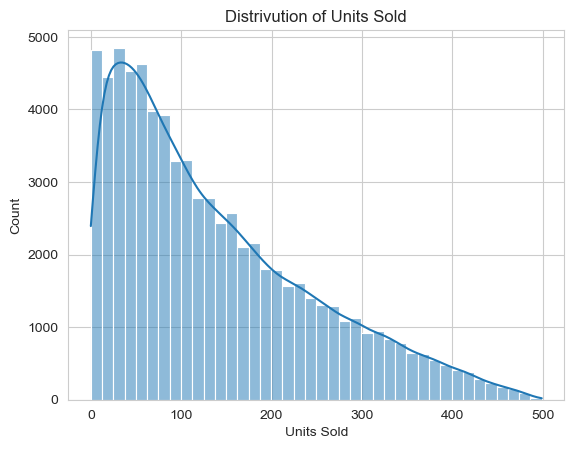

In [31]:
plt.Figure(figsize=(8,5))
sns.histplot(df['Units Sold'], bins=40, kde=True)
plt.title("Distrivution of Units Sold")
plt.show()

# Observations

- Most sales are small. The vast majority of the time, we sell a small number of items (the very tall bar on the left).
- Large sales are rare. It is much less common for us to sell a very high number of items at once (the flat tail stretching to the right).
- This is a normal retail pattern. This tells us our business relies on many consistent, small sales rather than a few giant ones.

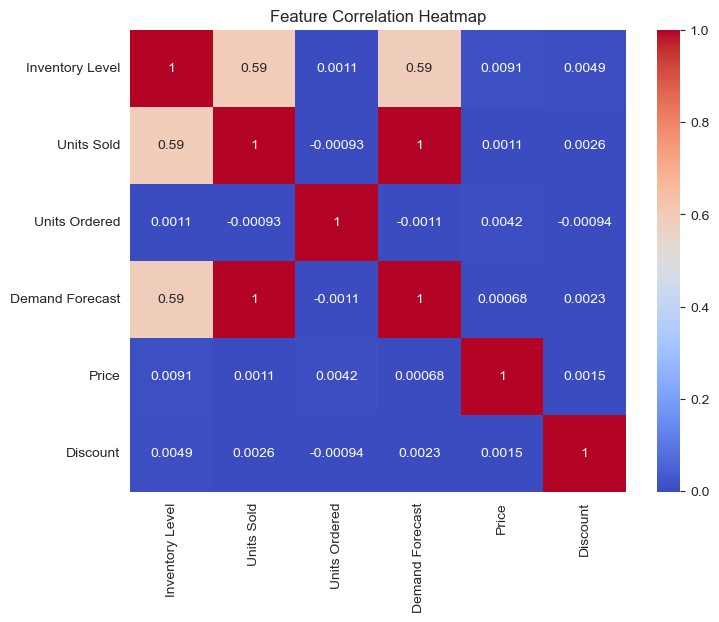

In [40]:
corr = df[['Inventory Level', 'Units Sold', 'Units Ordered', 'Demand Forecast', 'Price', 'Discount']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

### Strong Connections:

- Units Sold & Demand Forecast: These move together perfectly. If our forecast predicts high sales, we actually sell a lot.
- Inventory & Sales: When we have more inventory, we also tend to sell more.

### Weak or No Connections:

- Price and Discounts don't seem to have a strong link to how much we sell.
- Units Ordered doesn't relate strongly to anything else on this chart.

In simple terms: Sales are driven by having stock available and by accurate forecasts. Changing prices or discounts doesn't seem to affect sales much.

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(x='category', y='Units Sold', data=df, estimator=np.mean)
plt.title("Average Units Sold by Category")
plt.show()